In [1]:
import torch as tc
tc.set_default_tensor_type(tc.DoubleTensor)


In [2]:
from __future__ import division
import sys, platform, os

import numpy as np
import scipy as sp
from scipy.optimize import root

import MyHyperSphericaljl as jl
import MyOtherFunctions as fun

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [56]:
# K = 0

def TurningPoint(k, l):
    return tc.sqrt(l * (l+1)) / k

# Definitions for sink and tank functions

def sink(x):
    return x

def tank(x):
    return x

def dsink(x):
    return tc.ones_like(x)

def dtank(x):
    return tc.ones_like(x)

# Definitions for l=0 and l=1 modes

def Phi0nu(nu, x):
    return tc.sin(nu * x)/ nu / sink(x)

def Phi1nu(nu, x):
    return Phi0nu(nu, x) * (1 / tank(x) - nu / tc.tan(nu * x)) / nu

def dPhi0nu(nu, x):
    return (nu * tc.cos(nu * x) * sink(x) - tc.sin(nu * x) * dsink(x)) / nu / sink(x)**2

# Recurrence coefficients

def alphal(nu, l, x):
    return (2*l + 1) / tank(x) / nu

def betal(l):
    return tc.tensor([-1], dtype=tc.float64)

def ratio_list_modified(k, x, lmax):

    res = tc.zeros([lmax, len(x)])
    l_large = 2 * lmax

    temp = - k * tank(x) / (2 * l_large + 1)
    for ll in tc.arange(l_large - 1, lmax - 1, -1):
        temp = betal(ll) / (alphal(k, ll, x) + temp)
        
    res[-1] = temp # which corresponds to y_{lmax}/y_{lmax-1}
    llist = tc.arange(lmax - 2, 0, -1)
    for li in llist:
        res[li] = betal(li + 1) / (alphal(k, li + 1, x) + res[li+1])

    return res

In [73]:
def sp_jl(k, x, lmax = 2000):
    '''
        Input:  k           float
                x           (N) torch tensor

        Output: j_l^nu    (lmax * N) torch tensor
    '''

    x_matrix = k * x * tc.ones([lmax, len(x)])
    l_matrix = tc.arange(lmax, dtype=tc.int32).reshape([lmax,1])

    phi = sp.special.spherical_jn(l_matrix, x_matrix)

    return phi #, dphi

def Recurrence(k, x, lmax = 2000):
    '''
        Input:  k           float (=nu in non-flat case)
                x           (N) torch tensor

        Output: j_l         (lmax * N) torch tensor
    '''

    phi = tc.zeros([lmax, len(x)])
    # dphi = tc.zeros([lmax, len(x)])
    # nu = tc.tensor(nu_int, dtype=tc.float64)

    phi[0] = Phi0nu(k, x)
    phi[1] = Phi1nu(k, x)

    llist = tc.arange(2, lmax, dtype=tc.int32)
    rlist = ratio_list_modified(k, x, lmax)

    # dphi[0] = dPhi0nu(nu, x)
    # dphi[1] = dPhiByPhi_recurrence(nu, 1, rlist[0], x) * phi[1]

    for li in llist:
        phi[li] = tc.where(x > TurningPoint(k, li),  # turning point condition
                            alphal(k, li-1, x) * phi[li-1] + betal(li-1) * phi[li-2],  # forward recurrence
                            -rlist[li - 1] * phi[li - 1]) # backward recurrence
        
        # dphi[li] = dPhiByPhi_recurrence(nu, li, rlist[li], x) * phi[li]

    return phi #, dphi

In [74]:
testx = tc.linspace(0.001, 100*tc.pi, 1000)

res1 = sp_jl(1., testx)
res2 = Recurrence(tc.tensor([1]), testx)

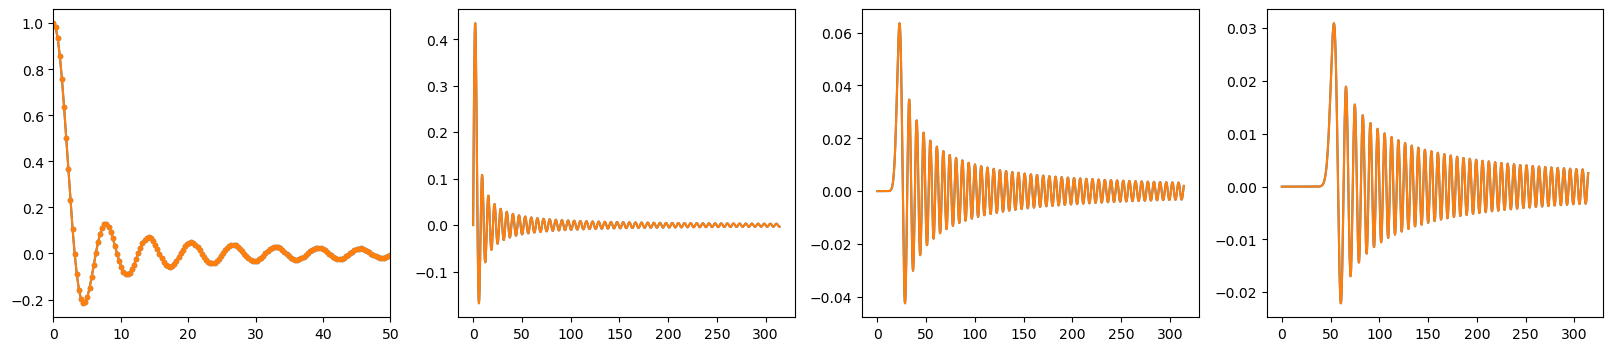

In [75]:
fig = plt.figure(figsize=(20,4))


plt.subplot(141)
plt.plot(testx, res1[0], '.-')
plt.plot(testx, res2[0], '.-')
plt.xlim([0,50])

plt.subplot(142)
plt.plot(testx, res1[1], '-')
plt.plot(testx, res2[1], '-')
# plt.xlim([-3,1])

plt.subplot(143)
plt.plot(testx, res1[20], '-')
plt.plot(testx, res2[20], '-')
# plt.xlim([-3,1])

plt.subplot(144)
plt.plot(testx, res1[50], '-')
plt.plot(testx, res2[50], '-')
# plt.xlim([-3,1])

plt.show()

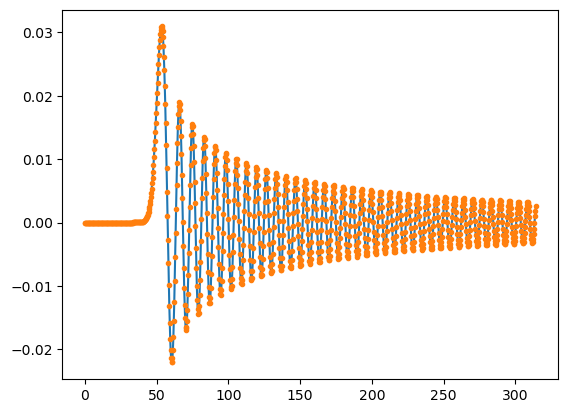

In [76]:
plt.plot(testx, res1[50], '-')
plt.plot(testx, res2[50], '.')